# **12. 태깅 작업(Tagging Task)**
자연어 처리 분야에서 각 단어가 어떤 유형에 속해있는지를 알아내는 태깅 작업에 대해서 배웁니다. 이러한 단어 태깅 작업의 대표적인 예시 두 가지로 각 단어의 유형이 사람, 장소, 단체 등 어떤 유형인지를 알아내는 **개체명 인식(Named Entity Recognition)** 과 각 단어의 품사가 명사, 동사, 형용사 인지를 알아내는 **품사 태깅(Part-of-Speech Tagging)** 이 있습니다. 이번 챕터에서는 RNN의 다 대 다(many-to-many) 구조를 사용하여 인공 신경망 기반의 개체명 인식기와 품사 태거를 만드는 미니 프로젝트를 수행해보겠습니다.

## **12-01 케라스를 이용한 태깅 작업 개요(Tagging Task using Keras)**
---
이번 챕터에서는 케라스(Keras)로 인공 신경망을 이용하여 **태깅 작업** 을 하는 모델을 만듭니다. **개체명 인식기 (Named Entity Recognition)** 와 **품사 태거(POS Tagger)** 를 만드는데, 이러한 두 작업의 공통점은 RNN의 **다-대-다(Many-to-Many)** 작업이면서 또한 앞, 뒤 시점의 입력을 모두 참고하는 **양방향 RNN(Bidirectional RNN)** 을 사용한다는 점입니다. 전체적으로 실습의 진행 방향을 정리해보겠습니다. 정확한 이해를 위해 텍스트 분류 개요 챕터와 비교하며 같이 읽기를 권합니다.

### **1.훈련 데이터에 대한 이해**
---

태깅 작업은 앞서 배운 텍스트 분류 작업과 동일하게 지도 학습(Supervised Learning)에 속합니다. 이 챕터에서는 태깅을 해야하는 단어 데이터를 X, 레이블에 해당되는 태깅 정보 데이터는 y라고 이름을 붙였습니다. X에 대한 훈련 데이터는 X_train, 테스트 데이터는 X_test라고 명명하고 y에 대한 훈련 데이터는 y_train, 테스트 데이터는 y_test라고 명명합니다.

이번 챕터에서 X와 y데이터의 쌍(pair)은 병렬 구조를 가진다는 특징을 가집니다. X와 y의 각 데이터의 길이는 같습니다. 예를 들어 개체명 인식 데이터의 상위 4개 샘플만 출력해본다고 가정해보겠습니다. 데이터는 다음과 같은 구조를 가질 수 있습니다.

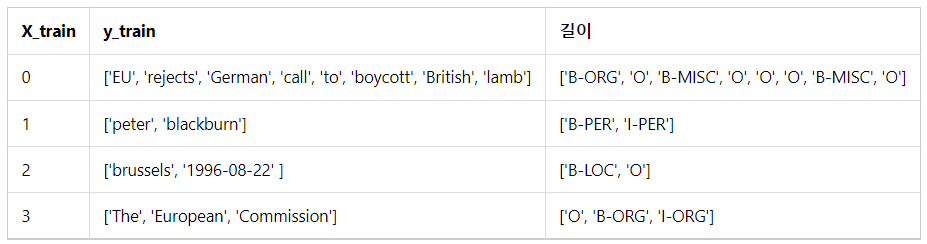

가령, X_train[3]의 'The'와 y_train[3]의 'O'는 하나의 쌍(pair)입니다. 또한, X_train[3]의 'European'과 y_train[3]의 'B-ORG'는 쌍의 관계를 가지며, X_train[3]의 'Commision'과 y_train[3]의 'I-ORG'는 쌍의 관계를 가집니다. 이렇게 병렬 관계를 가지는 토큰화가 이루어진 데이터는 정수 인코딩 과정을 거친 후, 모든 데이터의 길이를 동일하게 맞춰주기위한 패딩(Padding) 작업을 거친 후에 딥 러닝 모델의 입력으로 사용됩니다.

### **2.시퀀스 레이블링(Sequence Labeling)**
---
위와 같이 입력 시퀀스 X = [$x_1$, $x_2$, $x_3$, ..., $x_n$]에 대하여 레이블 시퀀스 y = [$y_1$, $y_2$, $y_3$, ..., $y_n$]를 각각 부여하는 작업을 시퀀스 레이블링 작업(Sequence Labeling Task)이라고 합니다. 태깅 작업은 대표적인 시퀀스 레이블링 작업입니다.

### **3.양방향 LSTM(Bidirectional LSTM)**
---
```python
    model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
```
이번 챕터에는 양방향 LSTM을 사용합니다. 이전 시점의 단어 정보 뿐만 아니라, 다음 시점의 단어 정보도 참고하기 위함입니다. 양방향은 기존의 단방향 LSTM()을 Bidirectional() 안에 넣으면 됩니다. LSTM의 인자값은 단방향 LSTM을 사용할 때와 동일합니다. 인자값을 하나를 줄 경우에는 이는 은닉 상태의 차원을 의미하며, 위 코드 상으로는 hidden_units로 기재되었습니다.

### **4.RNN의 다-대-다(Many-to-Many) 문제**
---
> 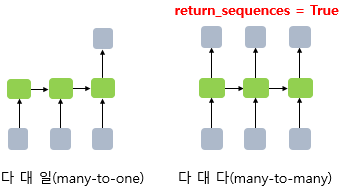

RNN의 은닉층은 모든 시점에 대해서 은닉 상태의 값을 출력할 수도, 마지막 시점에 대해서만 은닉 상태의 값을 출력할 수도 있습니다. 인자로 return_sequences=True를 넣을 것인지, 넣지 않을 것인지로(넣지 않으면 기본값은 False이므로 return_sequences=False로 인식.) 설정할 수 있는데 태깅 작업의 경우에는 다 대 다(many-to-many) 문제로 return_sequences=True를 설정하여 출력층에 모든 은닉 상태의 값을 보냅니다.

RNN이 어떻게 설계되는지 확인해보겠습니다. 예를 들어 위에서 설명한 데이터 중 첫번째 데이터에 해당되는 X_train[0]를 가지고 4번의 시점(time steps)까지 RNN을 진행하였을 때의 그림은 다음과 같습니다.  
  
>  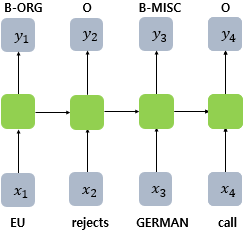

이번 실습에서는 양방향 RNN을 사용할 것이므로 아래의 그림과 같습니다.  
  
>  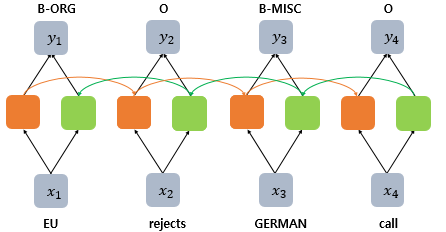